# Programming Assignment 4 (PA4): Gradient-Domain Copy Paste

### CS70 — Foundations of Applied Computer Science
---

This notebook contains literate code, i.e. brief fragments of Python surrounded by descriptive text (using Markdown). Please complete/extend this notebook for your homework submission:

* For any mathematical questions, make sure to **show you work**.
* For any questions that ask for code, please **also provide a short description of what your solution is doing and how it works**, either by adding comments or in an extra markdown cell.

Make sure to use the reference Python distribution so that project files can be opened by the TAs. In this course, we use [Anaconda](https://www.anaconda.com/products/individual), specifically the version based on Python 3.8.

<div class="alert alert-warning">
Homework assignments in CS70 count towards your final grade and must therefore be done individually.
</div>

## Import statements

We provide the import statements required to complete the assignment in the following cell. 

<div class="alert alert-danger" role="alert">
    <b>Import policy:</b> You must not use any <code>import</code>'s other than the ones we provide.
</div>

<div class="alert alert-info" role="alert">
    <b>Run</b> the following cell in the Jupyter Notebook to include the required modules. It imports libraries such as NumPy and Matplotlib and configures them to produce nice graphics.
</div>

In [1]:
import numpy as np  # for building and manipulating matrices
import time  # for measuring time elapsed while running code

# for sparse matrix operations
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as sla
from skimage.transform import resize

# for graphics
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# for interactive graph features
%matplotlib notebook  
%config InlineBackend.figure_format = 'retina'  # nice retina graphics

This assignment explores gradient-domain image processing, a simple technique with a broad set of applications including blending, tone-mapping, and non-photorealistic rendering. For the core project, we will focus on “Poisson blending".


You will be graded on the correctness, design, and efficiency of your code.


## Background
The primary goal of this assignment is to seamlessly blend an object or texture from a source image into a target image. The simplest method would be to just copy and paste the pixel values from one image directly into the other. Unfortunately, this will create very noticeable seams, even if the backgrounds are well-matched. How can we get rid of these seams without doing too much perceptual damage to the source region?

![](images/setup.png)

The insight is that our visual system is often more sensitive to the gradient of an image (how quickly the pixel values change left-right and up-down) than the overall intensity. We will therefore set up the problem as finding values for the pasted target pixels that maximally preserve the gradient of the source region without changing any of the background pixels. Note that we are making a deliberate decision here to ignore the overall intensity! So a green hat could turn red, but it will still look like a hat.

<div class="alert alert-info" role="alert">
<b>TODO: Implement the Least-Squares Solver</b>

You will implement `least_squares_2D`, which takes two parameters, `im_s` and `im_background`, each of which have dimensions $(W + 2) \times (H + 2)$. The function returns the interior region (`im_blend`, dimensions $W \times H$) of `im_s` and at the same time paste `im_blend` onto the interior region of `im_background`. Your tasks include the following:

<ol>
<li>Calculate the dimensions of `A` and `b`.</li>

<li>Create a matrix `im2var` to map each pixel of interest to a variable index (vectorization). </li>

<li>Initialize entries in `A` and `b`.</li>

<li>Solve the least-squares problem and save the results in `v`.</li>
    
<li>Assign the solved values to `im_blend`.</li>
</ol>

The starter code will return the resultant images as a `im_blend`. 
</div>

In [2]:
def least_squares_2D(im_s, im_background):
    #### initialize results to just be copies of the background
    im_blend = im_background.copy()
    
    #### initialize the size of source image 
    imh, imw = (im_s.shape[0], im_s.shape[1])    #### imh: image height, imw: image width
    imd = 1 if im_s.ndim < 3 else im_s.shape[2]  #### number of components of each pixel, e.g., for an RGB image, imd=3
    
    #### TODO 1: specify the number of unknowns and number of equations ####
    # Hint: num_vars = ?
    # Hint: num_eqns = ?
    num_vars = (imh-2) * (imw-2)
    num_eqns = 2*((imh-2) * (imw-2)) + (imw-2) + (imh-2)
    #### TODO END ####
    
    
    #### TODO 2: initialize the vectorization mapping ####
    # Hint: You need to create an im2var matrix with the same dimensions as im_s
    # and assign coordinates inside the 1 pixel padding unique numbers for easy indexing.
    # Hint: im2var = ?

    im2var = np.zeros((imh, imw))
    # Assigns the variable coordinates for each variable to solve for
    im2var[1:-1, 1:-1] = np.arange(0, (imh-2)*(imw-2)).reshape((imh-2, imw-2))

    #### TODO END ####
    
    #### check if the mapping is initialized correctly
    print(im2var)
    
    #### initialize A and b ####
    A = lil_matrix((num_eqns, num_vars))
    b = np.zeros((num_eqns, imd))
    
    #### TODO 3: fill the elements of A and b ####
    #### Hint: This is the major step of this assignment.
    #### Hint: Initialize all the vertical constraints first and then all the horizontal constraints
    #### Hint: Write a for loop to go through all the columns (for vertical constraints) and all the rows (for horizontal ones)
    #### Hint: For each column, consider three cases: upper boundary, interior, and lower boundary
    #### Hint: For each boundary case, consider how to initialize b
    #### Hint: Here you don't need to initialize each component of b separately. Instead, do it as a whole like b[e]=...

    # Initializes A and b
    counter = 0
    # Assigns vertical constraints (horizontal borders)
    for i in range(1, imw-1):
        for j in range(imh-1):
            # Upper pixel
            x1 = im_s[j][i]
            # Lower pixe
            x2 = im_s[j+1][i]
            # Boundary pixel if needed
            x3 = 0
            
            # Lower boundary case
            if j == 0:
                x3 = im_background[j][i]
                b[counter] = x2 - x1 + x3
                A[counter,im2var[j+1][i]] = 1
            # Upper boundary case
            elif j+1 == imh-1:
                x3 = im_background[j+1][i]
                b[counter] = x3 - x2 + x1
                A[counter,im2var[j][i]] = 1
            # Standard case
            else:
                b[counter] = x2 - x1 + x3
                A[counter,im2var[j][i]] = -1
                A[counter,im2var[j+1][i]] = 1
            
            counter += 1
        
    # Assigns horizontal constraints (vetical borders)
    for i in range(1, imh-1):
        for j in range(imw-1):
            # Left pixel
            x1 = im_s[i][j]
            # Right pixel
            x2 = im_s[i][j+1]
            # Boundary pixel if needed
            x3 = 0
            
            # Lower boundary case
            if j == 0:
                x3 = im_background[i][j]
                b[counter] = x2 - x1 + x3
                A[counter,im2var[i][j+1]] = 1
            # Upper boundary case
            elif j+1 == imw-1:
                x3 = im_background[i][j+1]
                b[counter] = x3 - x2 + x1
                A[counter,im2var[i][j]] = 1
            # Standard case
            else:
                b[counter] = x2 - x1 + x3
                A[counter,im2var[i][j]] = -1
                A[counter,im2var[i][j+1]] = 1
            
            counter += 1

    #### TODO END ####
    
    #### solve the least-squares problem
    
    #### convert A to (CSR) sparse format
    A = A.tocsr()
    
    print('Solving sparse system using sla.lsqr...')
    t = time.time()

    #### solve for all channels
    for c in range(0,imd):
        #### TODO 4: solve the least-squares problem Av=b, with the right-hand side specified by the c'th column of b ####
        #### Hint: This is just one line of code
        #### Hint: Use the function 'sla.lsqr' to solve the least-squares problem for efficiency.
        #### Hint: 'sla.lsqr' reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsqr.html
        #### Hint: Don't forget to specify the column index when you assign the results to v.

        v = sla.lsqr(A, b[:,c])[0]
            
        #### TODO END ####
        
        #### copy over to im_blend
        if im_s.ndim > 2: #### this branch is for rgb image
            #### TODO 5: reshape v to an appropriate shape and copy its values to the c'th component of im_blend ####
            #### Hint: This is just one line of code
            #### Hint: Consider using the function reshape.
            #### Hint: Be careful with the dimension

            im_blend[1:-1, 1:-1, c] = v.reshape((imh-2, imw-2))
            
            #### TODO END ####
            
        else:  #### this branch is for gray-scale image     
            #### TODO 5: reshape v to an appropriate shape and copy its values to im_blend ####
            #### Hint: This is just one line of code
            #### Hint: The same above. For an gray-scale image, you don't need to specify the third dimension (c)
            
            im_blend[1:-1, 1:-1] = v.reshape((imh-2, imw-2))
                    
            #### TODO END ####
    
    elapsed = time.time() - t
    print("\tTotal time for sparse solve: {} seconds \n".format(elapsed))

    #### return the blended result
    return im_blend

### Testing `least_squares_2D`

Test Case 1: Before testing `least_squares_2D` on a larger image, test it on the 4 x 4 `source_im` and `background_im` from the simple 2D section in the code block below. Display the source image, background image, the output using `sla.lsqr`, the output using the normal equations, and the expected result. **If implemented correctly, the output should be the exact same as the output expected in the simple 2D section.**

[[0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 2. 3. 0.]
 [0. 0. 0. 0.]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.0009181499481201172 seconds 



<IPython.core.display.Javascript object>


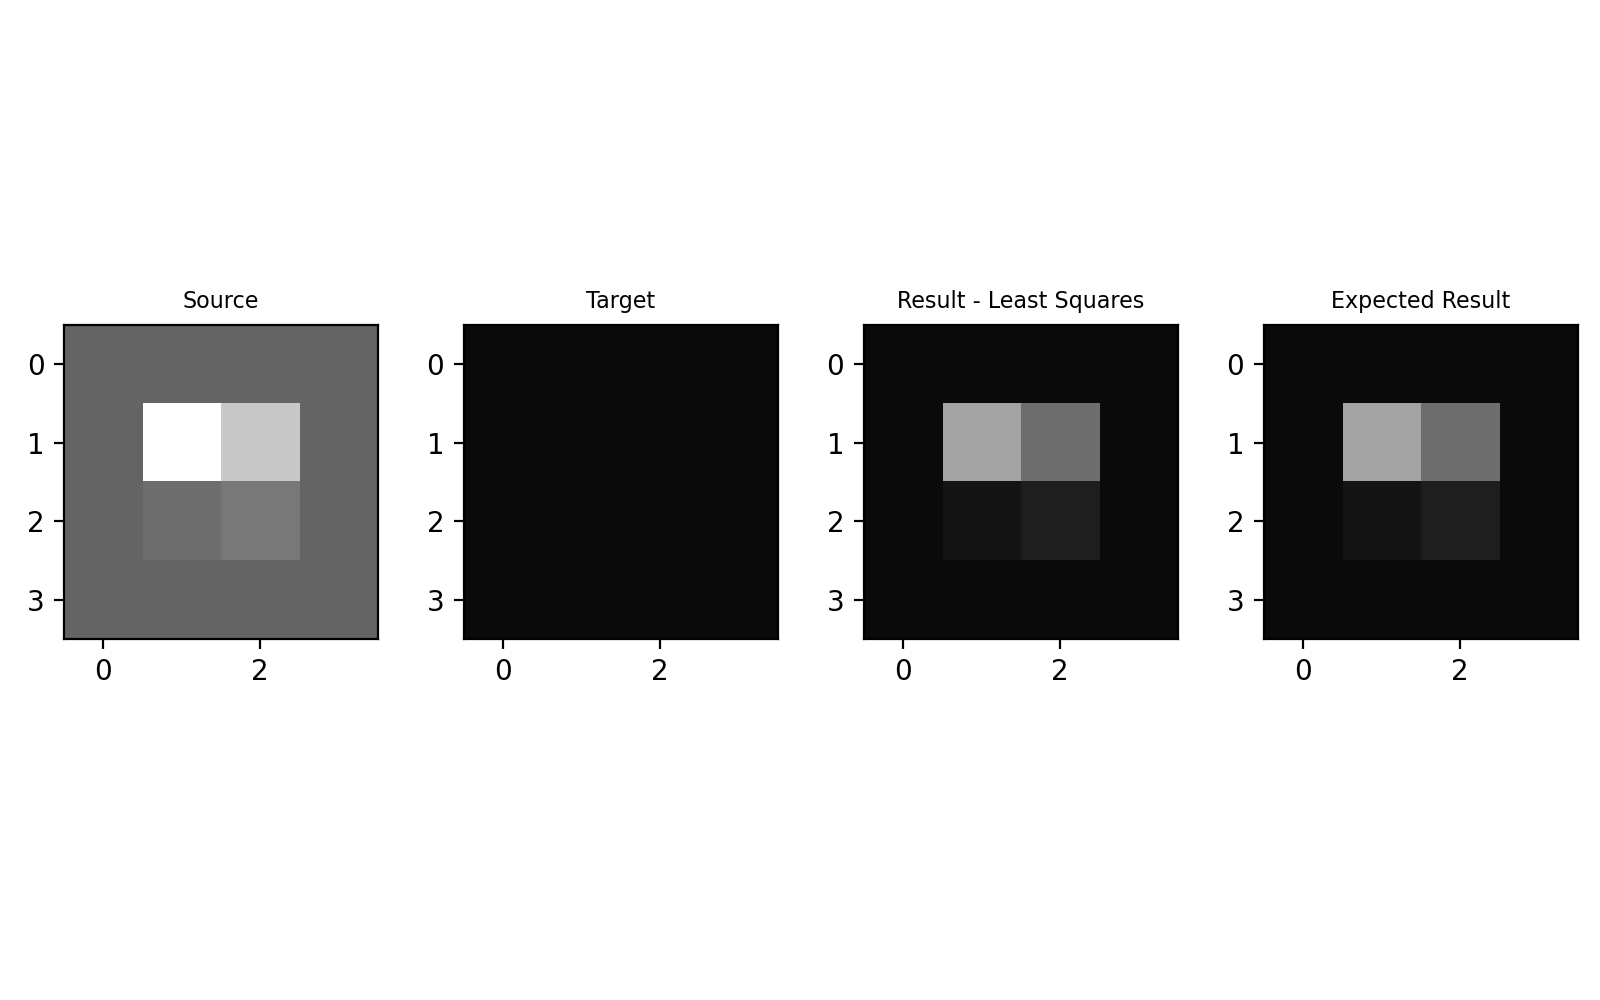

In [3]:
expected = np.array([[ 10,  10,  10,  10],
                     [ 10, 164, 110,  10],
                     [ 10,  20,  30,  10],
                     [ 10,  10,  10,  10]])

source_im = np.array([[100, 100, 100, 100],
                          [100, 255, 200, 100],
                          [100, 110, 120, 100],
                          [100, 100, 100, 100]])
background_im = np.array([[10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10],
                          [10, 10, 10, 10]])


# call least_squares_2D on source_im, background_im
# display source, target, sla.lsqr output, normal equation output, expected output

# simple paste of 2x2 square onto 4x4 square
size = 4
im_out = least_squares_2D(source_im, background_im)

fig, axs = plt.subplots(1,4)
fig.set_size_inches(8,5)
fig.tight_layout(pad=0.0)

#### draw source_im
axs[0].imshow(source_im, cmap='gray', vmin=0, vmax=255)
axs[0].set_title('Source', fontsize=8)
axs[0].set_yticks(np.arange(0, size))

#### draw background_im
axs[1].imshow(background_im, cmap='gray', vmin=0, vmax=255)
axs[1].set_title('Target', fontsize=8)
axs[1].set_yticks(np.arange(0, size))

#### draw your result after calling least_squares_2D
axs[2].imshow(im_out, cmap='gray', vmin=0, vmax=255)
axs[2].set_title('Result - Least Squares', fontsize=8)
axs[2].set_yticks(np.arange(0, size))

#### draw the expected result
axs[3].imshow(expected, cmap='gray', vmin=0, vmax=255)
axs[3].set_title('Expected Result', fontsize=8)
axs[3].set_yticks(np.arange(0, size))

plt.show()

Test Case 2: Now we load `toyim = plt.imread('images/toy_problem.png')`. Create `im_background` by creating a matrix with the same dimensions as `toyim` filled with the value at the top left corner of `toyim` using np.full [see numpy.full documentation](https://numpy.org/doc/stable/reference/generated/numpy.full.html). We will test `least_squares_2D` on a larger image by reconstructing `toyim`. Run `least_squares_2D` on `toyim` and `im_background`, and display the two reconstructed images with titles.

The program will give the error value between your reconstructed image(either) and the original image as a printed statement (using `np.linalg.norm` may be of use). **If you implemented everything correctly, you should see the same original and reconstructed images and the error value should be a small number.**

[[0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 ... 1.0600e+02 1.0700e+02 0.0000e+00]
 [0.0000e+00 1.0800e+02 1.0900e+02 ... 2.1400e+02 2.1500e+02 0.0000e+00]
 ...
 [0.0000e+00 1.2420e+04 1.2421e+04 ... 1.2526e+04 1.2527e+04 0.0000e+00]
 [0.0000e+00 1.2528e+04 1.2529e+04 ... 1.2634e+04 1.2635e+04 0.0000e+00]
 [0.0000e+00 0.0000e+00 0.0000e+00 ... 0.0000e+00 0.0000e+00 0.0000e+00]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.18595504760742188 seconds 



<IPython.core.display.Javascript object>


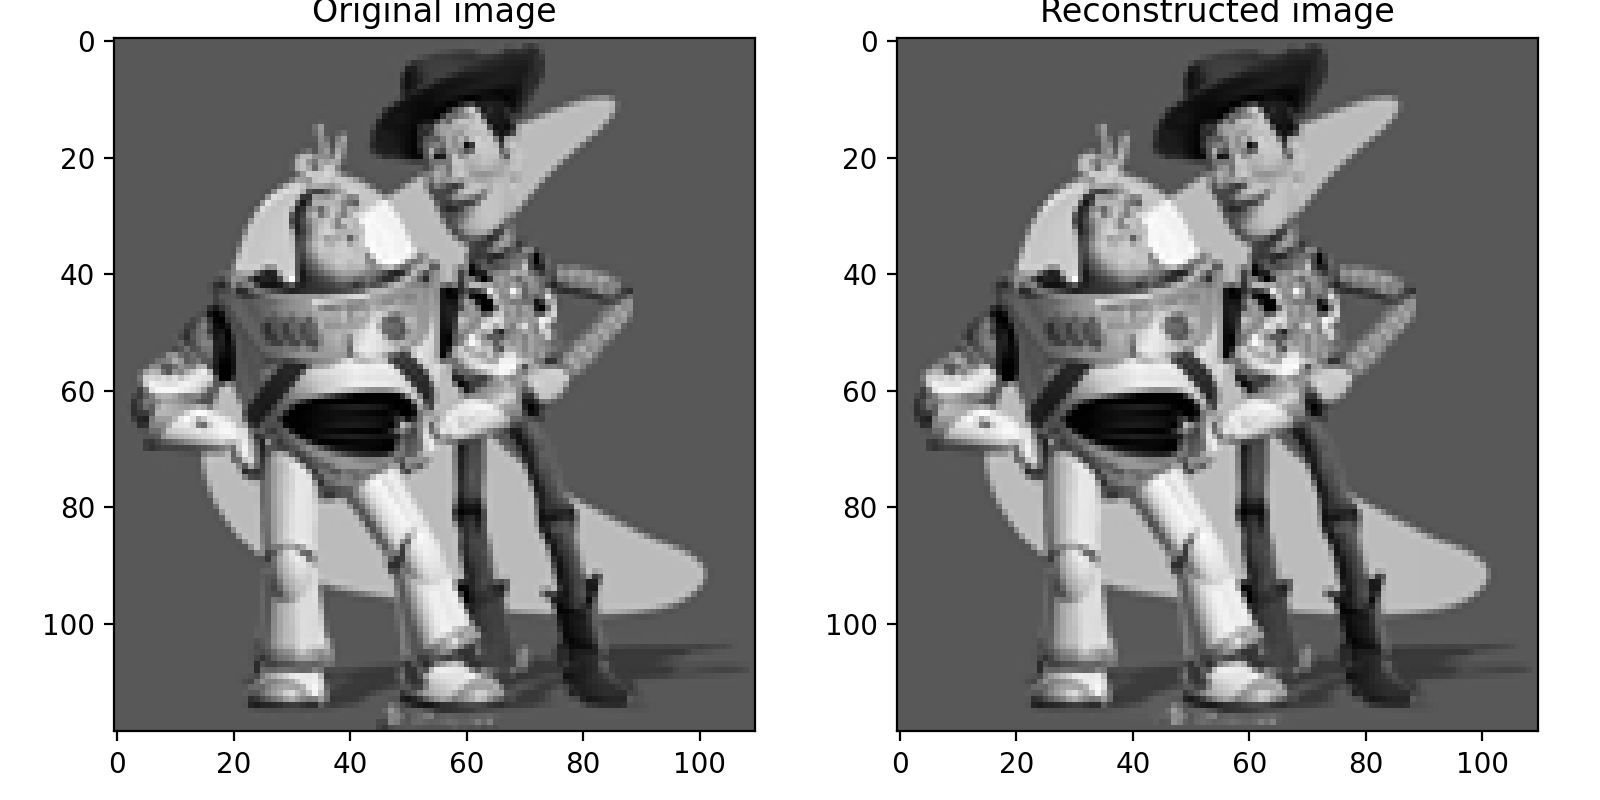

Error: 2.6384806523712833e-05


In [4]:
toyim = plt.imread('images/toy_problem.png')
im_background = np.full(toyim.shape, toyim[0, 0])

im_out = least_squares_2D(toyim, im_background)

# show the original image
fig2, axs2 = plt.subplots(1,2)
fig2.tight_layout(pad=1.0)
fig2.set_size_inches(8,4)

axs2[0].imshow(toyim, cmap = plt.cm.gray)
axs2[0].set_title("Original image")
    
# show the reconstruction
axs2[1].imshow(im_out, cmap = plt.cm.gray)
axs2[1].set_title("Reconstructed image")  

print('Error: {error}'.format(error=np.linalg.norm(im_out - toyim)/(toyim.size)))
plt.show()

## Poisson Blending

For Poisson Blending, you will select a coordinate on the background image which will serve as the bottom right corner for an object image to be blended into the background image. Ideally, the background of the object image and the surrounding area of the target region will be of similar color. 

**You need to run the following cell and select the coordinates for the gradient blend by clicking on the interactive figure. The interactive figure should draw a rectangle where the object image will appear in the blended image.**

<IPython.core.display.Javascript object>


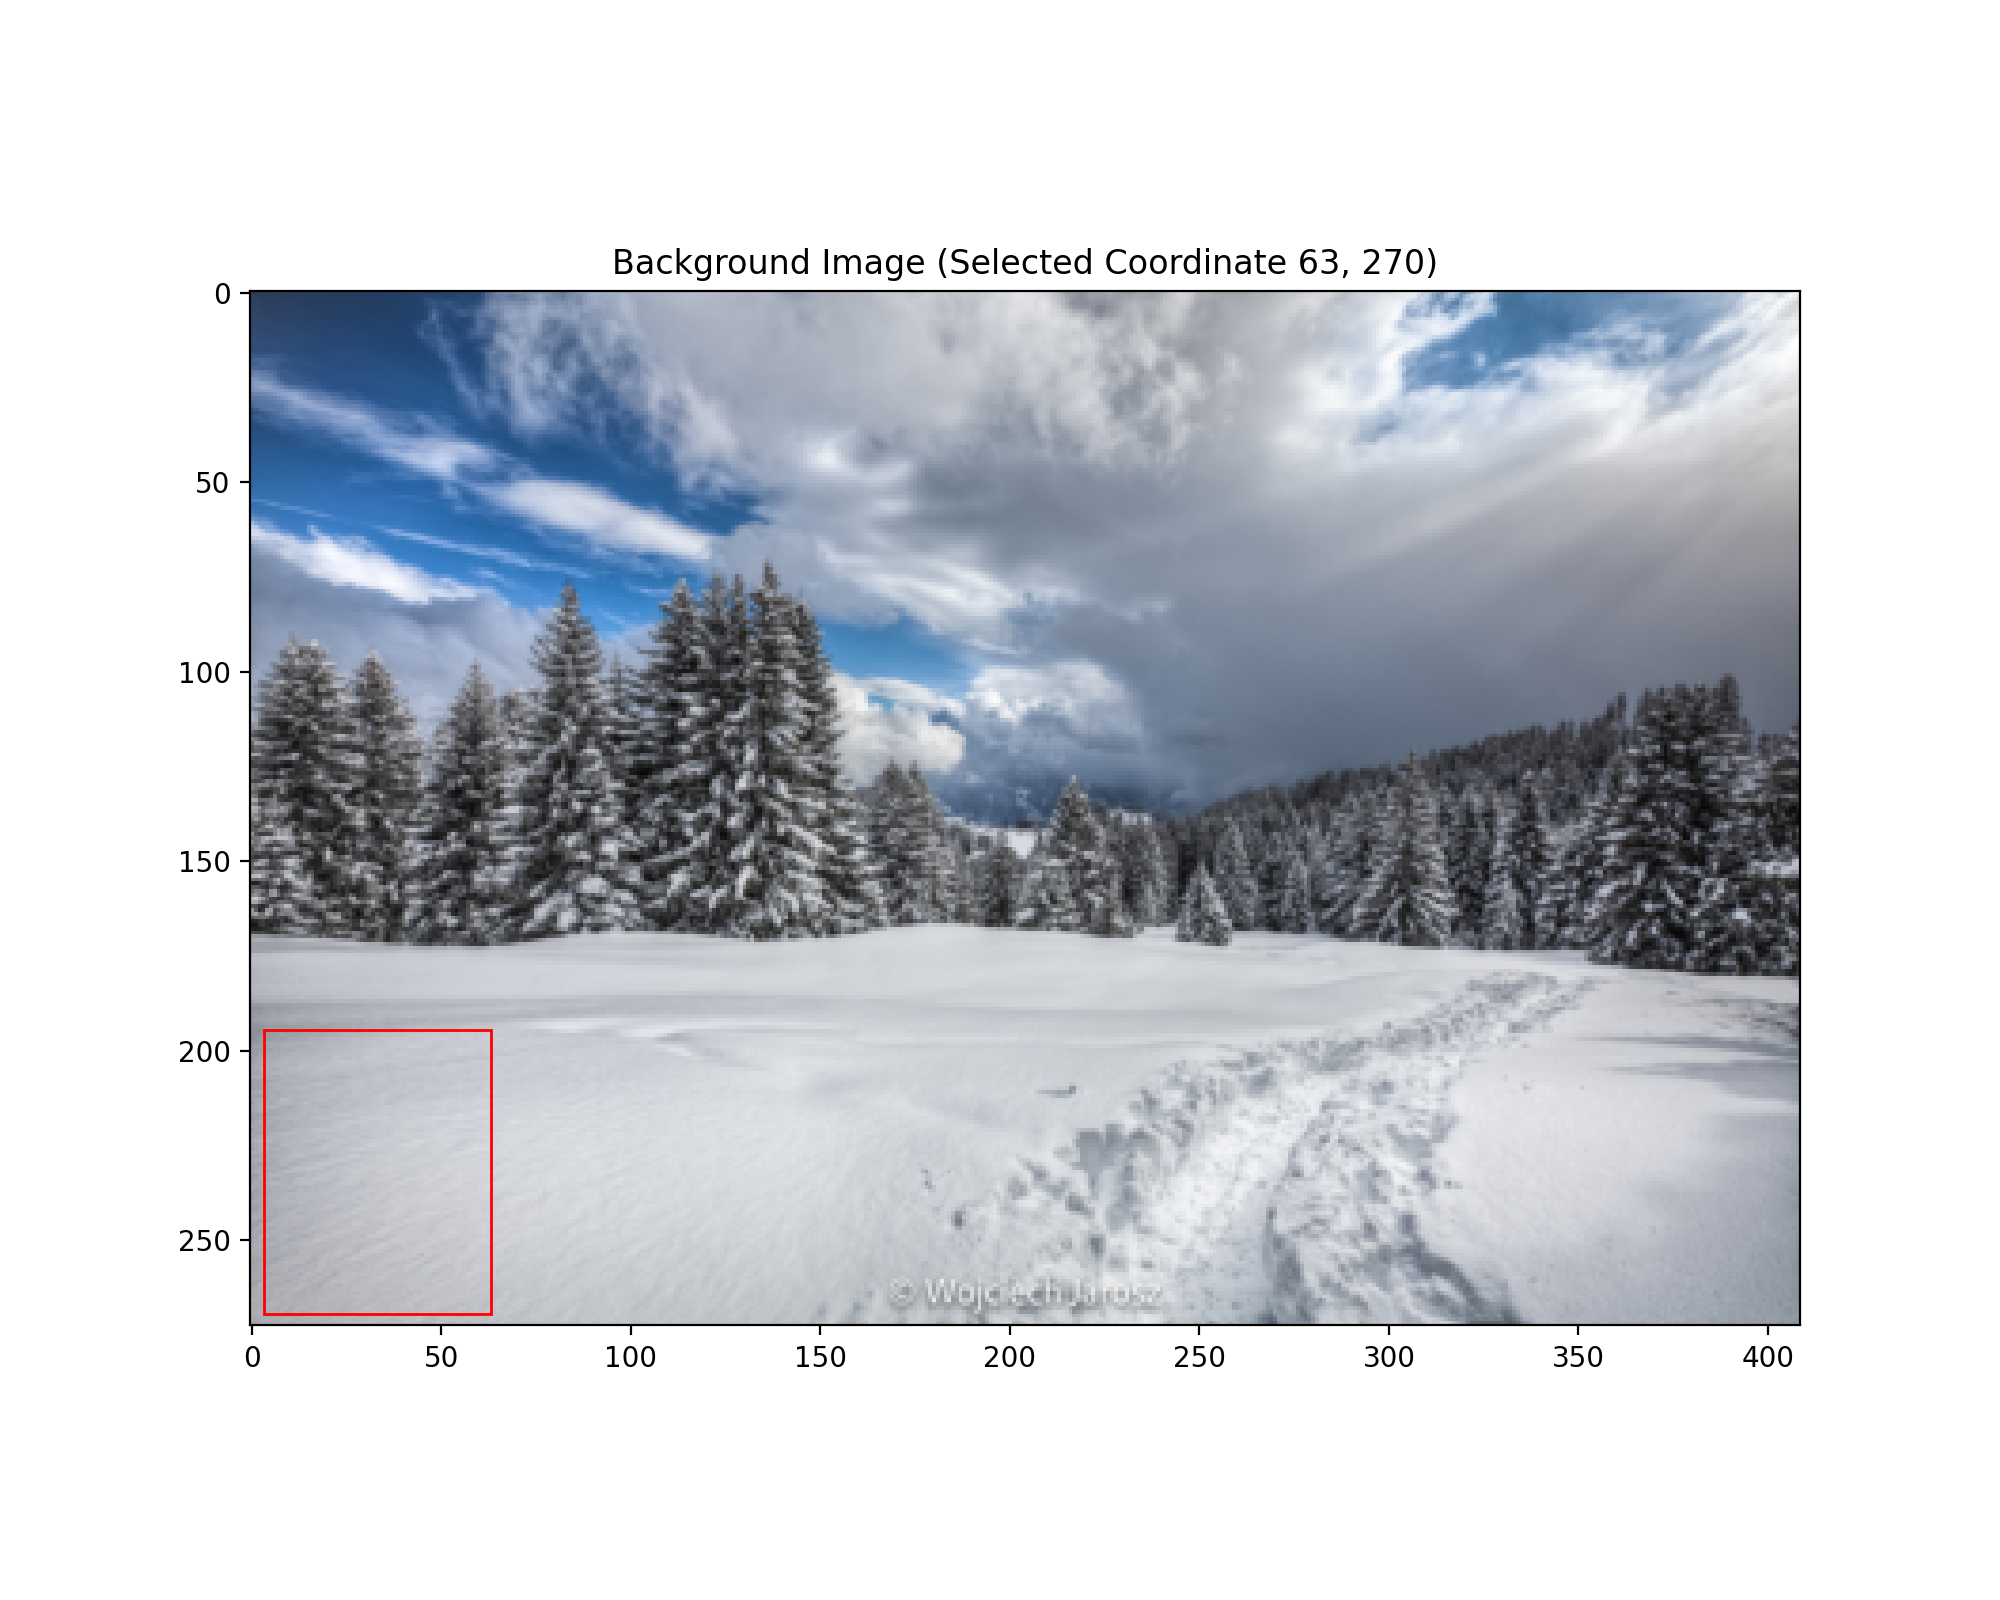

In [5]:
## new gradient domain copy-paste code should go here
# read in background and object images
im_background = plt.imread('images/background.jpg')/255.0
im_object = plt.imread('images/penguin-chick.jpg')/255.0
#
# reduce the size of the image for faster performance while debugging
# You can comment these two lines out to use the full-resolution images
im_background = resize(im_background, (im_background.shape[0] // 5,
                                       im_background.shape[1] // 5),
                       anti_aliasing=True)
im_object = resize(im_object, (im_object.shape[0] // 5,
                               im_object.shape[1] // 5),
                       anti_aliasing=True)

# get source region mask from the user
objh, objw, _ = im_object.shape
objmask = np.ones((objh, objw))

# for storing the selected coordinates aligning blending
coords = np.zeros(2)

# handling coordinate selection by storing selected coordinates
def onclick(event):
    global coords, objh, objw
    coords = np.round([event.xdata, event.ydata]).astype(np.int)
    plt.title(f"Background Image (Selected Coordinate {coords[0]}, {coords[1]})")
    # draw rectangle on image
    rect = Rectangle((event.xdata-objw,event.ydata-objh),objw,objh,linewidth=1,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)

# display interactive figure for selecting coordinate in background image
fig = plt.figure()
fig.set_size_inches(10,8)
plt.imshow(im_background)
cid = fig.canvas.mpl_connect('button_press_event', onclick) # for handling button click
plt.title("Background Image (Click a place to blend object image)")
plt.show()

<div class="alert alert-info" role="alert">
<b>TODO: Implement the Copy Copy-Paste Operation</b>
    
Below, we provide you `simple_copy_paste` which simply copies the pixel values from `im_object` onto the appropriate location of `im_background`.

Your task is to implement `poisson_copy_paste` which takes three parameters: `coords`, the coordinates of the bottom right corner of the region to blend, `im_object`, the image to paste into the background image, and `im_background`, the unaltered background image. You already cut out an appropriate region of `im_background` in the previous step. As the last step of this assignment, you need to **(1) solve the `im_blend` for the blended region using the `least_squares_2D` you implemented and (2) paste the results back into the appropriate region of a copy of `im_background` (named `res` in the code).** 
</div>

In [6]:
def simple_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape
    
    # paste pixel values into im_background
    result = im_background.copy()
    result[y-objh:y, x-objw:x, :] = im_object
    
    return result

def poisson_copy_paste(coords, im_object, im_background):
    x, y = coords
    objh, objw, _ = im_object.shape

    res = im_background.copy()
    background = im_background[y-objh:y, x-objw:x, :]
    
    #### TODO: cut out the appropriate region of im_background and paste back into im_background ####
    
    res[y-objh:y, x-objw:x, :] = least_squares_2D(im_object, background)
    
    #### TODO END ####
    
   
    
    return res

<div class="alert alert-info" role="alert">
    Run `poisson_copy_paste` and display your blended image. If implemented correctly, print statements from the code should appear detailing the progress and time needed to execute least squares. You might need to restrict the blended image values to between 0 and 1 by calling `.clip(0,1)` on your blended images.
</div>

<IPython.core.display.Javascript object>


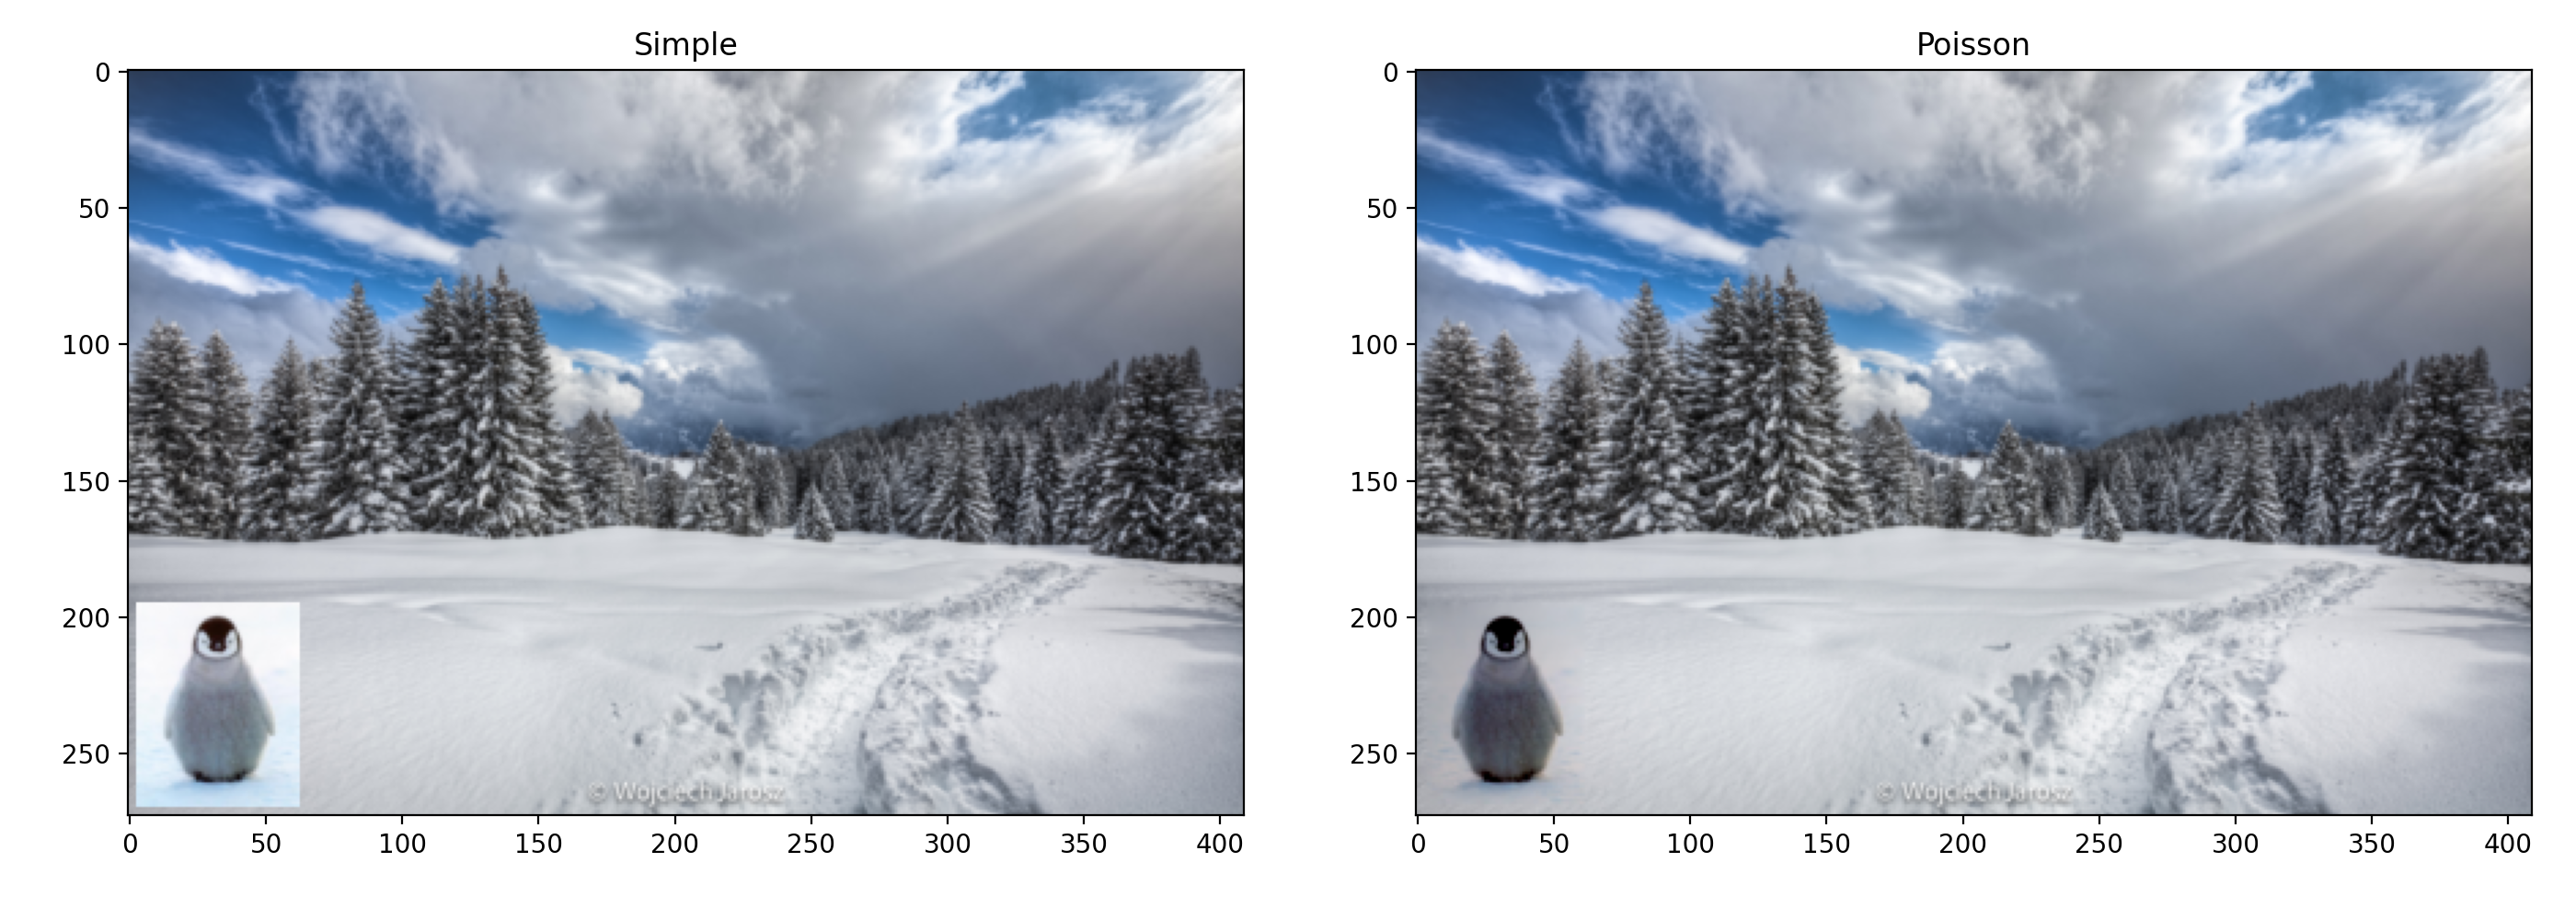

[[0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 1.000e+00 ... 5.600e+01 5.700e+01 0.000e+00]
 [0.000e+00 5.800e+01 5.900e+01 ... 1.140e+02 1.150e+02 0.000e+00]
 ...
 [0.000e+00 4.118e+03 4.119e+03 ... 4.174e+03 4.175e+03 0.000e+00]
 [0.000e+00 4.176e+03 4.177e+03 ... 4.232e+03 4.233e+03 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 ... 0.000e+00 0.000e+00 0.000e+00]]
Solving sparse system using sla.lsqr...
	Total time for sparse solve: 0.15601396560668945 seconds 



In [7]:
res0 = simple_copy_paste(coords, im_object, im_background)

fig3, axs3 = plt.subplots(1,2)
fig3.tight_layout(pad=0.0)
fig3.set_size_inches(14,5)

# show simple copy-paste first
axs3[0].imshow(res0.clip(0, 1))
axs3[0].set_title("Simple")

# TODO: your code here
# add two more sub-plots with your poisson copy-paste results

res1 = poisson_copy_paste(coords, im_object, im_background)

# show poisson copy-paste
axs3[1].imshow(res1.clip(0, 1))
axs3[1].set_title("Poisson")

### TODO END
plt.show()

## Submitting your work

Before handing in via Canvas, make sure:
  * your notebook runs from top to bottom after selecting "Kernel->Restart & Run All" without causing any errors. To simplify the grading process, please do **not** clear the generated output.
  * you've included any scans/images that your notebook references.
  * you've renamed the provided notebook according to your name and netid as: **[YourFirstName]\_[YourLastName]\_[YourNetId]\_[Assignment].ipynb**. For example, if John Doe has netid **F00237S**, his submission filename for SA1 should be **John_Doe_F00237S_SA1.ipynb**.
  
## References
This assignment is based off of a [similar one](http://graphics.cs.cmu.edu/courses/15-463/2010_fall/hw/proj2g/) from CMU.